# Installing t5 model


In [1]:
!pip install simplet5

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 65.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_

# Importing necessary libraries

In [1]:
import re
import json
import pandas as pd
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split
from typing import Dict, Any, Generator, Tuple, Optional
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import torch
import os
import torch
import numpy as np
from transformers import (
    T5ForConditionalGeneration,
    MT5ForConditionalGeneration,
    ByT5Tokenizer,
    PreTrainedTokenizer,
    RobertaTokenizer,
    T5TokenizerFast as T5Tokenizer,
    MT5TokenizerFast as MT5Tokenizer,
)
from transformers import AutoTokenizer
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelWithLMHead, AutoTokenizer
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from transformers import BertTokenizer


Mounted at /content/drive


INFO:pytorch_lightning.utilities.seed:Global seed set to 42


# Reading the data

In [2]:
file_path = "/content/drive/MyDrive/arxiv-metadata-oai-snapshot.json"
def dataset_reader_generator(path: str) -> Generator:
    with open(path, "r") as file_pointer:
        for line in file_pointer:
            row = json.loads(line)
            yield row
dataset_generator = dataset_reader_generator(path=file_path)

In [3]:
total_papers = 2000
def generate_dataframe_from_generator(generator: Generator) -> pd.DataFrame:
    titles_list = []
    authors_list = []
    abstracts_list = []
    categories_list = []
    dates_list = []
    for row in generator:
        if len(abstracts_list) == total_papers:
            break
        titles_list.append(row["title"])
        authors_list.append(row["authors"])
        dates_list.append(row["update_date"])
        abstracts_list.append(row["abstract"])
        categories_list.append(row["categories"])
    return pd.DataFrame.from_dict({
        "title": titles_list,
        "authors": authors_list,
        "date": dates_list,
        "abstract": abstracts_list,
        "categories": categories_list
    })
papers = create_dataframe(dataset_generator)
papers["date"] = pd.to_datetime(papers["date"])

In [4]:
papers

,title,authors,date,abstract,categories
0,Calculation of prompt diphoton production cros...,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",2008-11-26,A fully differential calculation in perturba...,hep-ph
1,Sparsity-certifying Graph Decompositions,Ileana Streinu and Louis Theran,2008-12-13,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG
2,The evolution of the Earth-Moon system based o...,Hongjun Pan,2008-01-13,The evolution of Earth-Moon system is descri...,physics.gen-ph
3,A determinant of Stirling cycle numbers counts...,David Callan,2007-05-23,We show that a determinant of Stirling cycle...,math.CO
4,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,Wael Abu-Shammala and Alberto Torchinsky,2013-10-15,In this paper we show how to compute the $\L...,math.CA math.FA
...,...,...,...,...,...
1995,A Wave-function for Stringy Universes,"Costas Kounnas, Nicolaos Toumbas and Jan Troost",2009-11-13,We define a wave-function for string theory ...,hep-th
1996,"Query on Negative Temperature, Internal Intera...",Yi-Fang Chang,2007-05-23,"After negative temperature is restated, we f...",physics.gen-ph
1997,Absence of the Fifth Force Problem in a Model ...,E. I. Guendelman and A. B. Kaganovich,2008-11-26,A scale invariant model containing dilaton $...,gr-qc astro-ph hep-th
1998,Dark matter caustics and the enhancement of se...,"Roya Mohayaee, Sergei Shandarin, Joseph Silk",2009-11-13,Cold dark matter haloes are populated by cau...,astro-ph


# Checking for missing values

In [5]:
papers.isnull().sum()

title         0
authors       0
date          0
abstract      0
categories    0
dtype: int64

#### No missing values

# Visualization

#### Abstract size

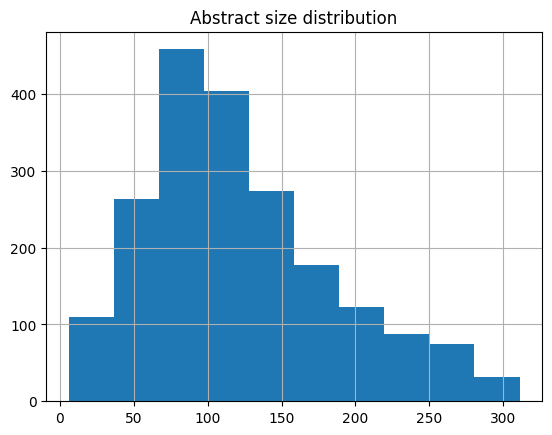

In [7]:
papers["abstract_len"] = papers["abstract"].apply(lambda text: len(text.split()))
papers["abstract_len"].hist()
plt.title("Abstract size distribution")
plt.show()

#### Number of categories per paper

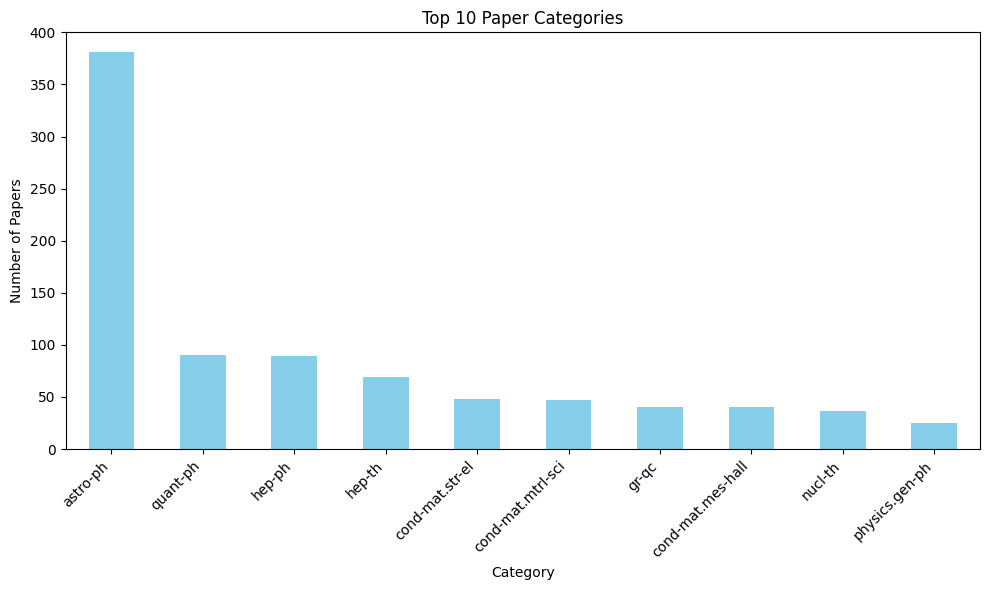

In [8]:
category_counts = papers['categories'].value_counts().head(10)
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Top 10 Paper Categories')
plt.xlabel('Category')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Wordcloud of abstracts

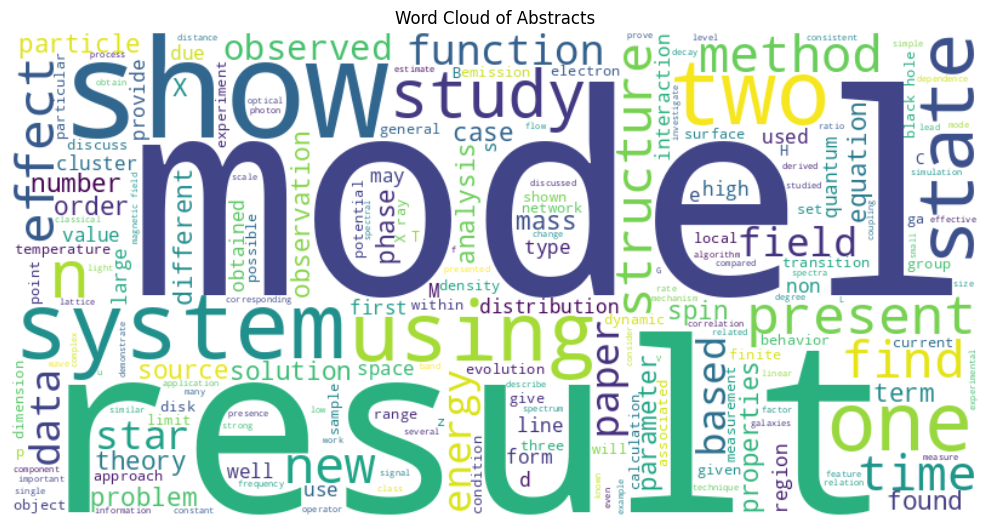

In [9]:
abstracts = ' '.join(papers['abstract'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(abstracts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Abstracts')
plt.axis('off')
plt.tight_layout()
plt.show()

# Preprocessing

In [10]:
def preprocess_data(dataset: pd.DataFrame) -> pd.DataFrame:
    dataset = remove_newlines_whitespace(dataset)
    dataset = convert_to_lowercase(dataset)
    dataset = remove_special_characters(dataset)
    return dataset

def remove_newlines_whitespace(dataset: pd.DataFrame) -> pd.DataFrame:
    dataset['abstract'] = dataset['abstract'].apply(lambda text: text.replace("\n", ""))
    dataset['title'] = dataset['title'].apply(lambda text: text.replace("\n", ""))
    dataset['abstract'] = dataset['abstract'].apply(lambda text: re.sub('\s+', ' ', text))
    dataset['title'] = dataset['title'].apply(lambda text: re.sub('\s+', ' ', text))
    return dataset

def convert_to_lowercase(dataset: pd.DataFrame) -> pd.DataFrame:
    dataset["abstract"] = dataset["abstract"].str.lower()
    dataset["title"] = dataset["title"].str.lower()
    return dataset

def remove_special_characters(dataset: pd.DataFrame) -> pd.DataFrame:
    dataset["abstract"] = dataset["abstract"].apply(remove_special_chars)
    dataset["title"] = dataset["title"].apply(remove_special_chars)
    return dataset

def remove_special_chars(text: str) -> str:
    text = re.sub(r"[^\w\d\s]+", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

if __name__ == "__main__":
    papers = preprocess_data(papers)

In [11]:
papers = papers[['abstract','title']]
papers.columns = ["source_text", "target_text"]
papers['source_text'] = "summarize: "+ papers['source_text']

<ipython-input-11-4a3f1e78d257>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  papers['source_text'] = "summarize: "+ papers['source_text']


In [12]:
papers

,source_text,target_text
0,summarize: a fully differential calculation in...,calculation of prompt diphoton production cros...
1,summarize: we describe a new algorithm the k e...,sparsity certifying graph decompositions
2,summarize: the evolution of earth moon system ...,the evolution of the earth moon system based o...
3,summarize: we show that a determinant of stirl...,a determinant of stirling cycle numbers counts...
4,summarize: in this paper we show how to comput...,from dyadic lambda_ alpha to lambda_ alpha
...,...,...
1995,summarize: we define a wave function for strin...,a wave function for stringy universes
1996,summarize: after negative temperature is resta...,query on negative temperature internal interac...
1997,summarize: a scale invariant model containing ...,absence of the fifth force problem in a model ...
1998,summarize: cold dark matter haloes are populat...,dark matter caustics and the enhancement of se...


# Model Training

#### Splitting the data

In [13]:
train_df, test_df = train_test_split(papers, test_size=0.3)

#### Model Architecture

In [19]:
torch.cuda.empty_cache()
pl.seed_everything(42)
class PyTorchDataModule(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: PreTrainedTokenizer,
        source_max_token_len: int = 512,
        target_max_token_len: int = 512,
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.source_max_token_len = source_max_token_len
        self.target_max_token_len = target_max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):

        data_row = self.data.iloc[index]
        source_text = data_row["source_text"]

        source_text_encoding = self.tokenizer(
            source_text,
            max_length=self.source_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt",
        )

        target_text_encoding = self.tokenizer(
            data_row["target_text"],
            max_length=self.target_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt",
        )

        labels = target_text_encoding["input_ids"]
        labels[
            labels == 0
        ] = -100
        return dict(
            source_text_input_ids=source_text_encoding["input_ids"].flatten(),
            source_text_attention_mask=source_text_encoding["attention_mask"].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=target_text_encoding["attention_mask"].flatten(),
        )
class LightningDataModule(pl.LightningDataModule):

    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: PreTrainedTokenizer,
        batch_size: int = 4,
        source_max_token_len: int = 512,
        target_max_token_len: int = 512,
        num_workers: int = 2,
    ):
        super().__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.source_max_token_len = source_max_token_len
        self.target_max_token_len = target_max_token_len
        self.num_workers = num_workers

    def setup(self, stage=None):
        self.train_dataset = PyTorchDataModule(
            self.train_df,
            self.tokenizer,
            self.source_max_token_len,
            self.target_max_token_len,
        )
        self.test_dataset = PyTorchDataModule(
            self.test_df,
            self.tokenizer,
            self.source_max_token_len,
            self.target_max_token_len,
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )
class LightningModel(pl.LightningModule):

    def __init__(
        self,
        tokenizer,
        model,
        outputdir: str = "outputs",
        save_only_last_epoch: bool = False,
    ):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.outputdir = outputdir
        self.average_training_loss = None
        self.average_validation_loss = None
        self.save_only_last_epoch = save_only_last_epoch

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask,
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_size):
        input_ids = batch["source_text_input_ids"]
        attention_mask = batch["source_text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels,
        )

        self.log(
            "train_loss", loss, prog_bar=True, logger=True, on_epoch=True, on_step=True
        )
        return loss

    def validation_step(self, batch, batch_size):
        input_ids = batch["source_text_input_ids"]
        attention_mask = batch["source_text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels,
        )

        self.log(
            "val_loss", loss, prog_bar=True, logger=True, on_epoch=True, on_step=True
        )
        return loss

    def test_step(self, batch, batch_size):
        input_ids = batch["source_text_input_ids"]
        attention_mask = batch["source_text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels,
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

    def training_epoch_end(self, training_step_outputs):
        self.average_training_loss = np.round(
            torch.mean(torch.stack([x["loss"] for x in training_step_outputs])).item(),
            4,
        )
        path = f"{self.outputdir}/simplet5-epoch-{self.current_epoch}-train-loss-{str(self.average_training_loss)}-val-loss-{str(self.average_validation_loss)}"
        if self.save_only_last_epoch:
            if self.current_epoch == self.trainer.max_epochs - 1:
                self.tokenizer.save_pretrained(path)
                self.model.save_pretrained(path)
        else:
            self.tokenizer.save_pretrained(path)
            self.model.save_pretrained(path)

    def validation_epoch_end(self, validation_step_outputs):
        _loss = [x.cpu() for x in validation_step_outputs]
        self.average_validation_loss = np.round(
            torch.mean(torch.stack(_loss)).item(),
            4,
        )


class SimpleT5:
    def __init__(self) -> None:
        pass

    def from_pretrained(self, model_type="t5", model_name="t5-base") -> None:
        if model_type == "t5":
            self.tokenizer = T5Tokenizer.from_pretrained(f"{model_name}")
            self.model = T5ForConditionalGeneration.from_pretrained(
                f"{model_name}", return_dict=True
            )
        elif model_type == "mt5":
            self.tokenizer = MT5Tokenizer.from_pretrained(f"{model_name}")
            self.model = MT5ForConditionalGeneration.from_pretrained(
                f"{model_name}", return_dict=True
            )
        elif model_type == "byt5":
            self.tokenizer = ByT5Tokenizer.from_pretrained(f"{model_name}")
            self.model = T5ForConditionalGeneration.from_pretrained(
                f"{model_name}", return_dict=True
            )
        elif model_type =="codet5":
            self.tokenizer = RobertaTokenizer.from_pretrained(f"{model_name}")
            self.model = T5ForConditionalGeneration.from_pretrained(
                f"{model_name}", return_dict=True
            )

    def train(
        self,
        train_df: pd.DataFrame,
        eval_df: pd.DataFrame,
        source_max_token_len: int = 512,
        target_max_token_len: int = 512,
        batch_size: int = 8,
        max_epochs: int = 5,
        use_gpu: bool = True,
        outputdir: str = "outputs2",
        early_stopping_patience_epochs: int = 0,
        precision=32,
        logger="default",
        dataloader_num_workers: int = 2,
        save_only_last_epoch: bool = False,
    ):
        self.data_module = LightningDataModule(
            train_df,
            eval_df,
            self.tokenizer,
            batch_size=batch_size,
            source_max_token_len=source_max_token_len,
            target_max_token_len=target_max_token_len,
            num_workers=dataloader_num_workers,
        )

        self.T5Model = LightningModel(
            tokenizer=self.tokenizer,
            model=self.model,
            outputdir=outputdir,
            save_only_last_epoch=save_only_last_epoch,
        )

        callbacks = [TQDMProgressBar(refresh_rate=5)]

        if early_stopping_patience_epochs > 0:
            early_stop_callback = EarlyStopping(
                monitor="val_loss",
                min_delta=0.00,
                patience=early_stopping_patience_epochs,
                verbose=True,
                mode="min",
            )
            callbacks.append(early_stop_callback)

        gpus = 1 if use_gpu else 0
        loggers = True if logger == "default" else logger
        trainer = pl.Trainer(
            logger=loggers,
            callbacks=callbacks,
            max_epochs=max_epochs,
            gpus=gpus,
            precision=precision,
            log_every_n_steps=1,
        )

        trainer.fit(self.T5Model, self.data_module)

    def load_model(
        self, model_type: str = "t5", model_dir: str = "outputs2", use_gpu: bool = False
    ):
        if model_type == "t5":
            self.model = T5ForConditionalGeneration.from_pretrained(f"{model_dir}")
            self.tokenizer = T5Tokenizer.from_pretrained(f"{model_dir}")
        elif model_type == "mt5":
            self.model = MT5ForConditionalGeneration.from_pretrained(f"{model_dir}")
            self.tokenizer = MT5Tokenizer.from_pretrained(f"{model_dir}")
        elif model_type == "byt5":
            self.model = T5ForConditionalGeneration.from_pretrained(f"{model_dir}")
            self.tokenizer = ByT5Tokenizer.from_pretrained(f"{model_dir}")
        elif model_type =="codet5":
            self.model = T5ForConditionalGeneration.from_pretrained(f"{model_dir}")
            self.tokenizer = RobertaTokenizer.from_pretrained(f"{model_dir}")

        if use_gpu:
            if torch.cuda.is_available():
                self.device = torch.device("cuda")
            else:
                raise
        else:
            self.device = torch.device("cpu")

        self.model = self.model.to(self.device)

    def predict(
        self,
        source_text: str,
        max_length: int = 512,
        num_return_sequences: int = 1,
        num_beams: int = 2,
        top_k: int = 50,
        top_p: float = 0.95,
        do_sample: bool = True,
        repetition_penalty: float = 2.5,
        length_penalty: float = 1.0,
        early_stopping: bool = True,
        skip_special_tokens: bool = True,
        clean_up_tokenization_spaces: bool = True,
    ):
        input_ids = self.tokenizer.encode(
            source_text, return_tensors="pt", add_special_tokens=True
        )
        input_ids = input_ids.to(self.device)
        generated_ids = self.model.generate(
            input_ids=input_ids,
            num_beams=num_beams,
            max_length=max_length,
            repetition_penalty=repetition_penalty,
            length_penalty=length_penalty,
            early_stopping=early_stopping,
            top_p=top_p,
            top_k=top_k,
            num_return_sequences=num_return_sequences,
        )
        preds = [
            self.tokenizer.decode(
                g,
                skip_special_tokens=skip_special_tokens,
                clean_up_tokenization_spaces=clean_up_tokenization_spaces,
            )
            for g in generated_ids
        ]
        return preds

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


## Model training

#### Mt5 Model training

In [16]:
model = SimpleT5()
model.from_pretrained("mt5", "t5-base")
model.train(train_df=train_df, eval_df=test_df, source_max_token_len=512, target_max_token_len=128, max_epochs=5, batch_size=8, use_gpu=True)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

You are using a model of type t5 to instantiate a model of type mt5. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Some weights of the model checkpoint at t5-base were not used when initializing MT5ForConditionalGeneration: ['decoder.block.5.layer.2.DenseReluDense.wi.weight', 'decoder.block.8.layer.2.DenseReluDense.wi.weight', 'encoder.block.9.layer.1.DenseReluDense.wi.weight', 'encoder.block.11.layer.1.DenseReluDense.wi.weight', 'decoder.block.2.layer.2.DenseReluDense.wi.weight', 'encoder.block.4.layer.1.DenseReluDense.wi.weight', 'encoder.block.2.layer.1.DenseReluDense.wi.weight', 'decoder.block.7.layer.2.DenseReluDense.wi.weight', 'encoder.block.0.layer.1.DenseReluDense.wi.weight', 'decoder.block.4.layer.2.DenseReluDense.wi.weight', 'encoder.block.10.layer.1.DenseReluDense.wi.weight', 'encoder.block.7.layer.1.DenseReluDense.wi.weight', 'encoder.block.3.layer.1.DenseReluDense.wi.weight', 'decoder.block.11.layer.2.DenseReluDense.wi.weight', 'encoder.block.5.layer.1.DenseReluDense.wi.weight', 'decoder.block.1.layer.2.DenseReluDense.wi.weight', 'decoder.block.10.layer.2.DenseReluDense.wi.weight', 'd

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:pytorch_lightning.utilities.seed:Global seed set to 42
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve p

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

#### T5 Model Training

In [18]:
model1 = SimpleT5()
model1.from_pretrained("t5", "t5-base")
model1.train(train_df=train_df, eval_df=test_df, source_max_token_len=512, target_max_token_len=128, max_epochs=5, batch_size=8, use_gpu=True)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

#### byt5 Model Training

In [20]:
model2 = SimpleT5()
model2.from_pretrained("byt5", "t5-base")
model2.train(train_df=train_df, eval_df=test_df, source_max_token_len=512, target_max_token_len=128, max_epochs=5, batch_size=8, use_gpu=True)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'ByT5Tokenizer'.
INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Results

#### mt5 Model

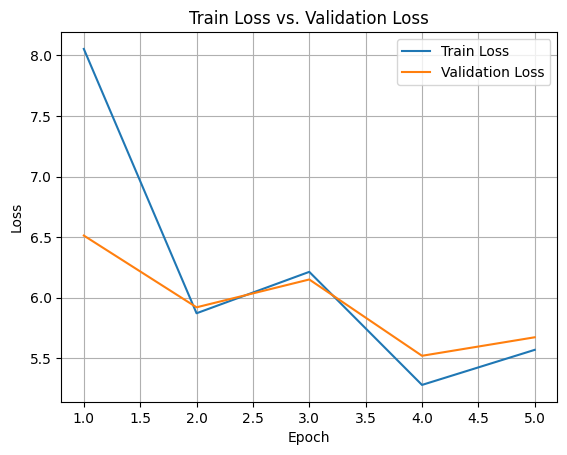

In [21]:
output_dir = "outputs"
pattern = re.compile(r"simplet5-epoch-(\d+)-train-loss-(\d+\.\d+)-val-loss-(\d+\.\d+)")
train_losses = []
val_losses = []
for filename in os.listdir(output_dir):
    match = pattern.match(filename)
    if match:
        train_loss = float(match.group(2))
        val_loss = float(match.group(3))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
avg_train_loss = sum(train_losses) / len(train_losses)
avg_val_loss = sum(val_losses) / len(val_losses)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#### t5 Model

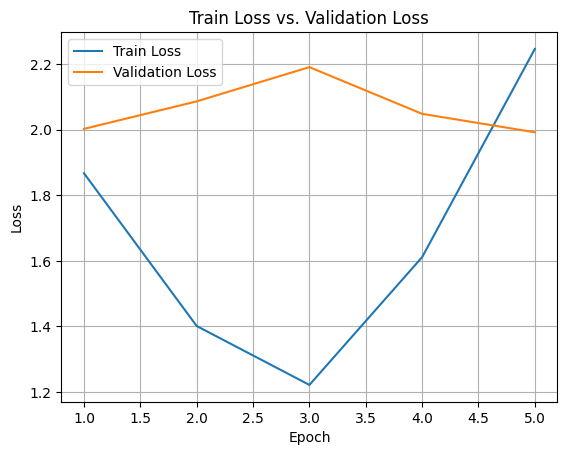

In [22]:
output_dir = "outputs1"
pattern = re.compile(r"simplet5-epoch-(\d+)-train-loss-(\d+\.\d+)-val-loss-(\d+\.\d+)")
train_losses = []
val_losses = []
for filename in os.listdir(output_dir):
    match = pattern.match(filename)
    if match:
        train_loss = float(match.group(2))
        val_loss = float(match.group(3))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
avg_train_loss = sum(train_losses) / len(train_losses)
avg_val_loss = sum(val_losses) / len(val_losses)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#### byt5 Model

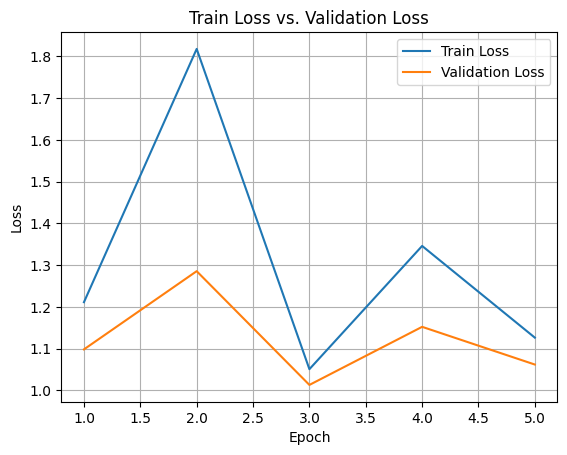

In [23]:
output_dir = "outputs2"
pattern = re.compile(r"simplet5-epoch-(\d+)-train-loss-(\d+\.\d+)-val-loss-(\d+\.\d+)")
train_losses = []
val_losses = []
for filename in os.listdir(output_dir):
    match = pattern.match(filename)
    if match:
        train_loss = float(match.group(2))
        val_loss = float(match.group(3))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
avg_train_loss = sum(train_losses) / len(train_losses)
avg_val_loss = sum(val_losses) / len(val_losses)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Prediction



#### mt5 Model

In [24]:
model.load_model("outputs/SimpleT5-epoch-4-train-loss-1.1588", use_gpu=True)
sample_abstracts = test_df.sample(3)
for i, abstract in sample_abstracts.iterrows():
    print(f"===== Abstract =====")
    print(abstract['source_text'])
    summary= model.predict(abstract['source_text'])[0]
    print(f"\n===== Actual Title =====")
    print(f"{abstract['target_text']}")
    print(f"\n===== Generated Title =====")
    print(f"{summary}")
    print("\n +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

===== Abstract =====
summarize: we introduce a finite volume scheme for the two dimensional incompressiblenavier stokes equations we use a triangular mesh the unknowns for thevelocity and pressure are both piecewise constant colocated scheme we use aprojection fractional step method to deal with the incompressibilityconstraint we prove that the differential operators in the navier stokesequations and their discrete counterparts share similar properties inparticular we state an inf sup babuska brezzi condition we infer from itthe stability of the scheme

===== Actual Title =====
stability of a colocated finite volume scheme for the incompressible navier stokes equations

===== Generated Title =====
the a 2 er snoid tcon

 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

===== Abstract =====
summarize: we apply recent bounds of the author math pr 0609224 for generalizedsmirnov statistics to the distribution of integers whose prime factors satisfycertain 

#### t5 Model

In [25]:
model1.load_model("outputs1/SimpleT5-epoch-4-train-loss-1.1588", use_gpu=True)
sample_abstracts = test_df.sample(3)
for i, abstract in sample_abstracts.iterrows():
    print(f"===== Abstract =====")
    print(abstract['source_text'])
    summary= model1.predict(abstract['source_text'])[0]
    print(f"\n===== Actual Title =====")
    print(f"{abstract['target_text']}")
    print(f"\n===== Generated Title =====")
    print(f"{summary}")
    print("\n +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

===== Abstract =====
summarize: a cylindrical wave expansion method is developed to obtain the scatteringfield for an ideal two dimensional cylindrical invisibility cloak a near idealmodel of the invisibility cloak is set up to solve the boundary problem at theinner boundary of the cloak shell we confirm that a cloak with the idealmaterial parameters is a perfect invisibility cloak by systematically studyingthe change of the scattering coefficients from the near ideal case to the idealone however due to the slow convergence of the zero th order scatteringcoefficients a tiny perturbation on the cloak would induce a noticeable fieldscattering and penetration

===== Actual Title =====
confirmation of cylindrical perfect invisibility cloak using fourier bessel analysis

===== Generated Title =====
a cylindrical wave expansion invisibility cloak

 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

===== Abstract =====
summarize: riemannian metric on real 2n d

#### byt5 Model

In [26]:
model2.load_model("outputs2/SimpleT5-epoch-4-train-loss-1.1588", use_gpu=True)
sample_abstracts = test_df.sample(3)
for i, abstract in sample_abstracts.iterrows():
    print(f"===== Abstract =====")
    print(abstract['source_text'])
    sumamary= model1.predict(abstract['source_text'])[0]
    print(f"\n===== Actual Title =====")
    print(f"{abstract['target_text']}")
    print(f"\n===== Generated Title =====")
    print(f"{summary}")
    print("\n +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

===== Abstract =====
summarize: the structure of anticyclic operad on the dendriform operad defines inparticular a matrix of finite order acting on the vector space spanned byplanar binary trees we compute its characteristic polynomial and propose a compatible conjecture for the characteristic polynomial of the coxetertransformation for the tamari lattice which is mostly a square root of thismatrix

===== Actual Title =====
le module dendriforme sur le groupe cyclique

===== Generated Title =====
schur weyl duality

 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

===== Abstract =====
summarize: the friedel oscillations resulting from coupling a quantum dot to one edge ofa disordered one dimensional wire in the mott insulator regime are calculatednumerically using the dmrg method by investigating the influence of thedisorder on the friedel oscillations decay we find that the effect of disorderis reduced by increasing the interaction strength this beha

# References

1.	Assignment 1 Submission for UB CSE 676-B Spring 24, Surya Kumaran Sainath (UBIT: sainath), Sankeerth Sridhar Narayan (UBIT: ss676)
2.  Assignment 0 Submission for UB CSE 676-B Spring 24, Sankeerth Sridhar Narayan (UBIT: ss676)
3.  https://huggingface.co/docs/transformers/en/model_doc/t5
4.  https://medium.com/geekculture/simplet5-train-t5-models-in-just-3-lines-of-code-by-shivanand-roy-2021-354df5ae46ba

